# TIME SERIES ANALYTICS - CONSUMO ENERGIA ELÉTRICA

O objetivo dessa análise preditiva é prever o consumo de energia elétrica nos próximos 365 dias com o uso do algoritmo de séries temporais Prophet que foi feito pelo núcleo de ciência de dados do Facebook.

As medições foram feitas minuto a minuto em uma casa na região de Sceaux (7km de Paris, France) dezembro de 2006 e dezembro de 2010.

A fonte dos dados: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

## 1. Carga dos Pacotes

In [1]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib import pylab
from prophet import Prophet
from datetime import datetime
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Carga dos Dados

In [2]:
# Carregando os dados
base = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

# Confere dataset e número de linhas
base.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 3. Pré-Processamento dos Dados

In [3]:
# Verifica o shape da base
# São 2 milhões registros e 9 atributos
base.shape

(2075259, 9)

In [4]:
# Resumo do dataset
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
# Verifica se há valores nulos
base.isnull().values.any()

True

In [6]:
# Contagem de valores nulos

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  25979
Isso corresponde a  1.3 %
Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.


In [7]:
# Remove registros nulos da base
# Pelo número de linhas, confirmamos que houve a remoção dos valores nulos
base = base.dropna()

# Confere dataset e número de linhas
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [8]:
# Alguns valores na base estão como "?" e neste caso vamos substituir por 0
base = base.replace(to_replace = ['?'], value = [0])

In [9]:
# Confere os valores nulos novamente

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 0% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  0
Isso corresponde a  0.0 %
Os registros nulos representam apenas 0% da base, dessa forma será melhor removê-los da base.


In [10]:
# Converte coluna de data em DateTime
base['Date'] = pd.to_datetime(base["Date"])

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [11]:
# Converte os demais atributos para tipo float64
base['Global_active_power'] = pd.to_numeric(base['Global_active_power'])
base['Global_reactive_power'] = pd.to_numeric(base['Global_reactive_power'])
base['Voltage'] = pd.to_numeric(base['Voltage'])
base['Global_intensity'] = pd.to_numeric(base['Global_intensity'])
base['Sub_metering_1'] = pd.to_numeric(base['Sub_metering_1'])
base['Sub_metering_2'] = pd.to_numeric(base['Sub_metering_2'])

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

In [12]:
# Cria coluna com o consumo doméstico total
base['total_consumo'] = base['Sub_metering_1'] + base['Sub_metering_2'] + base['Sub_metering_3']

# Confere os tipos de dados
base.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
total_consumo                   float64
dtype: object

In [13]:
# Confere dataset e número de linhas
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0
...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0


## 4. Análise Exploratória

In [14]:
# Cópia da base para análise exploratória
df = base

In [15]:
# Cria variáveis para agrupamento de datas

# Variável Ano
df['year'] = df['Date'].dt.year

# Variável Mês
df['month'] = df['Date'].dt.month

#Variável Ano-Mês
df['month_year'] = df['Date'].dt.to_period('M')

In [16]:
# Confere dataset e número de linhas
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo,year,month,month_year
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0,2006,12,2006-12
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0,2006,12,2006-12
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0,2006,12,2006-12
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0,2006,12,2006-12
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0,2006,12,2006-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0,2010,11,2010-11
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0,2010,11,2010-11
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0,2010,11,2010-11


In [17]:
# Data como index da base
df = df.set_index('Date')

# Confere dataset e número de linhas
df.head()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo,year,month,month_year
Date,,,,,,,,,,,,
2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0,2006,12,2006-12
2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0,2006,12,2006-12
2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0,2006,12,2006-12
2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0,2006,12,2006-12
2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0,2006,12,2006-12


Text(0.5, 0, ' ')

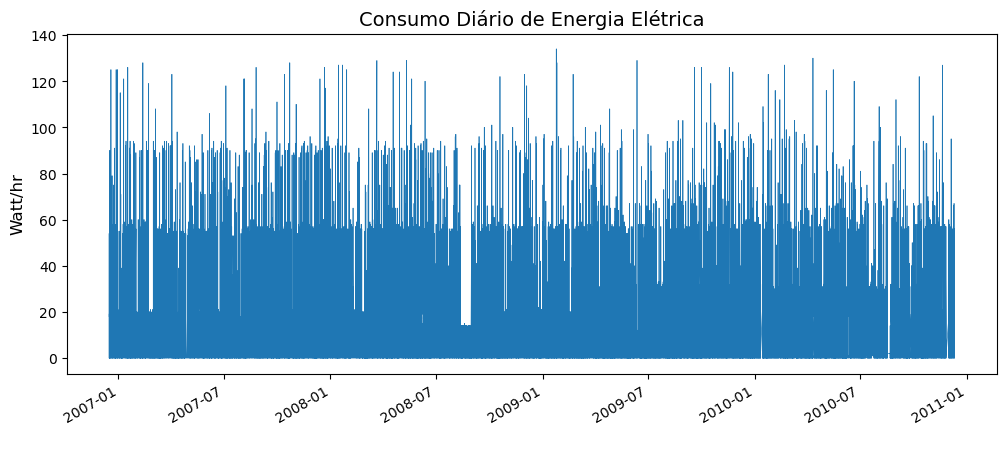

In [18]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['total_consumo'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

No gráfico fica um pouco difícil analisar porque temos uma série de valores zerados, por conta disso será feito uma breve análise com a média dia de consumo. 

In [19]:
# Analise da média de consumo  por área da casa ao longo do período
# Para a análise foi selecionado Voltage e as medições por área da casa
# Para a escolha foi levado em consideração que os demais atributos de certa forma estão relacionados ao consumo global da casa
# sendo que para essa análise o ideal seria verificar com mais detalhes a base de dados

df_media = base[['Date', 'Voltage','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'total_consumo']]

# Confere o numéro de linhas e colunas
df_media

,Date,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,2006-12-16,234.84,0.0,1.0,17.0,18.0
1,2006-12-16,233.63,0.0,1.0,16.0,17.0
2,2006-12-16,233.29,0.0,2.0,17.0,19.0
3,2006-12-16,233.74,0.0,1.0,17.0,18.0
4,2006-12-16,235.68,0.0,1.0,17.0,18.0
...,...,...,...,...,...,...
2075254,2010-11-26,240.43,0.0,0.0,0.0,0.0
2075255,2010-11-26,240.00,0.0,0.0,0.0,0.0
2075256,2010-11-26,239.82,0.0,0.0,0.0,0.0
2075257,2010-11-26,239.70,0.0,0.0,0.0,0.0


In [20]:
# Group by pela média do consumo diário
df_media = df_media.groupby(['Date'])[['Voltage','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','total_consumo']].mean()

# Confere o novo dataset
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
Date,,,,,
2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182
2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028
2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056
2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278
2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861
...,...,...,...,...,...
2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833
2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222
2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222


In [21]:
# Converte o objeto em dataframe pandas
df_media = pd.DataFrame(df_media)

# Confere dataset e número de linhas
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
Date,,,,,
2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182
2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028
2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056
2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278
2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861
...,...,...,...,...,...
2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833
2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222
2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222


In [22]:
# Reset do index para inclusão de colunas de tempo
df_media = df_media.reset_index()

# Confere dataset e número de linhas
df_media

,Date,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182
1,2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028
2,2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056
3,2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278
4,2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861
...,...,...,...,...,...,...
1428,2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833
1429,2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222
1430,2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222
1431,2010-12-10,240.260674,0.766667,0.541667,6.813889,8.122222


In [23]:
# Cria variáveis para agrupamento de datas

# Variável Ano
df_media['year'] = df_media['Date'].dt.year

# Variável Mês
df_media['month'] = df_media['Date'].dt.month

#Variável Ano-Mês
df_media['month_year'] = df_media['Date'].dt.to_period('M')

In [24]:
# Data como index da base
df_media = df_media.set_index('Date')

# Confere o dataset
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo,year,month,month_year
Date,,,,,,,,
2006-12-16,236.243763,0.000000,1.378788,12.439394,13.818182,2006,12,2006-12
2006-12-17,240.087028,1.411806,2.907639,9.264583,13.584028,2006,12,2006-12
2006-12-18,241.231694,0.738194,1.820139,9.734722,12.293056,2006,12,2006-12
2006-12-19,241.999313,0.582639,5.279167,4.303472,10.165278,2006,12,2006-12
2006-12-20,242.308062,0.000000,1.838889,9.765972,11.604861,2006,12,2006-12
...,...,...,...,...,...,...,...,...
2010-12-07,240.218646,1.197222,0.448611,4.475000,6.120833,2010,12,2010-12
2010-12-08,240.794931,0.000000,0.356944,2.765278,3.122222,2010,12,2010-12
2010-12-09,241.619722,1.253472,1.444444,6.174306,8.872222,2010,12,2010-12


Text(0.5, 0, ' ')

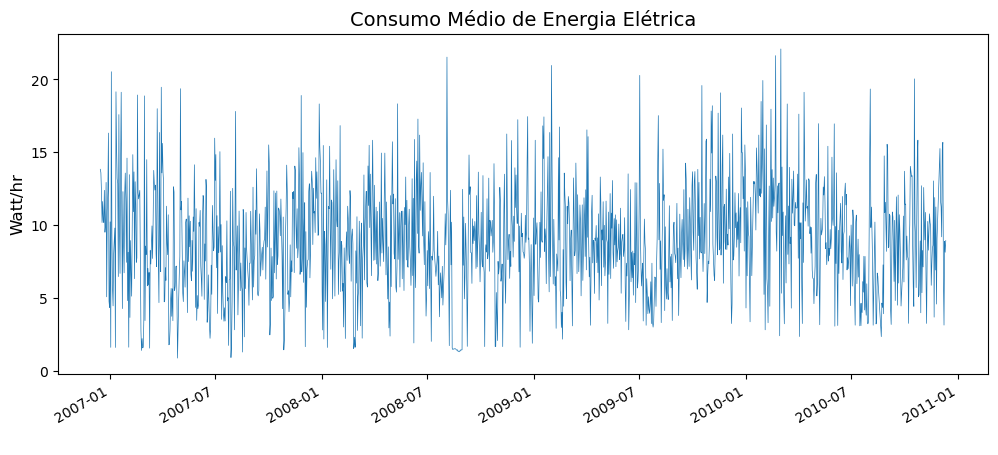

In [25]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df_media['total_consumo'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Médio de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

No gráfico com a média de consumo diário, é possível observar que o consumo mantém o mesmo nível ao longo dos anos. Nos meses de Julho temos uma queda no consumo, talvez pelo fato de ser férias e os moradores ficarem em outros lugares e após esse mês vemos uma alta no consumo de energia elétrica. 

Vale lembrar que as medições foram feitas na Europa, mais precisamente na França. Por conta da localização precisamos levar em considerar as estações, com temperaturas mais baixas a partir de dezembro e temperaturas mais altas a partir de julho. Esse aumento no consumo no final do ano pode estar relacionado ao aquecedor da casa.

Text(0, 0.5, 'total_consumo')

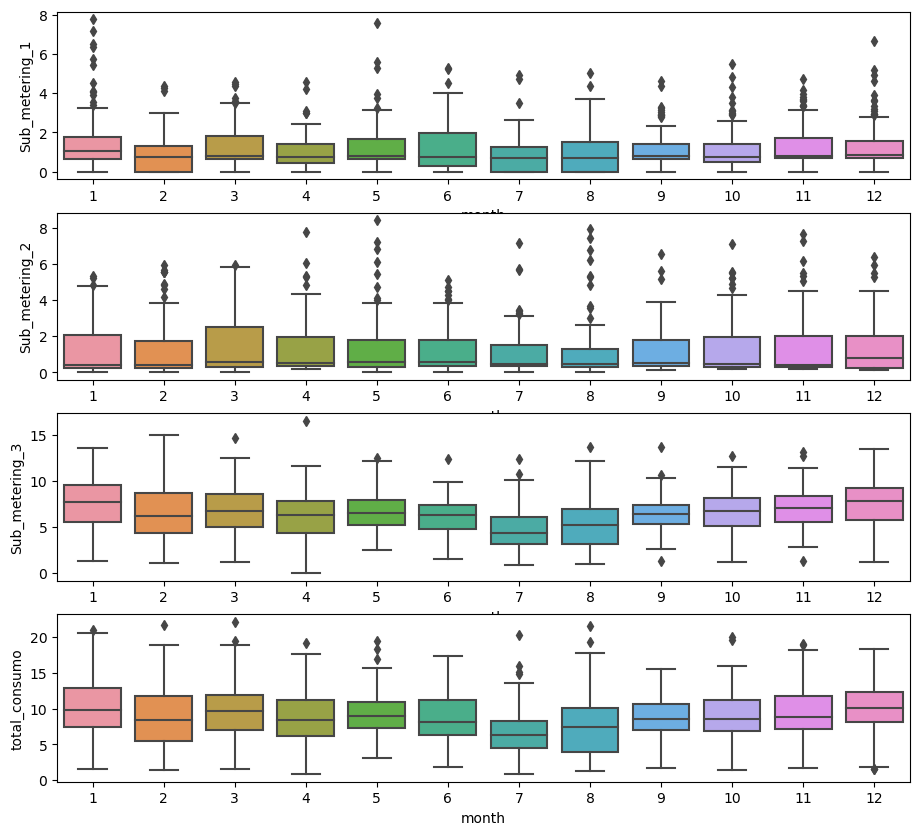

In [26]:
# Boxplot dos dados
# Ajuste no tamanho do gráfico
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=False)

# Plot com 3 variáveis
for name, ax in zip(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'total_consumo'], axes):

    sns.boxplot(data=df_media, x='month', y = name, ax = ax)

# Configura o eixo Y    
ax.set_ylabel(name)

Na análise com o consumo médio em Watt/hr pelas áreas da casa vemos que no primeiro boxplot, que representa a cozinha, tem um comportamento mais estável entre os demais, apesar de que entre outubro e janeiro a amostra possui muito outliers em comparação com o demais meses. Uma possibilidade, e que não está descrito na base, seja por conta das temperaturas na região estarem abaixo dos 10 ºC em média nessa época do ano as pessoas constumam aumentar o consumo doméstico para ficar mais em casa.

No segundo boxplot, relacionado a área da lavanderia, não vemos um comportamento muito atípico em relação ao consumo de energia elétrica. O terceiro boxplot, que é referente ao sistema de aquecimento/ar condicionado da casa, mostra que é o maior consumo entre todas as áreas medidas. O que faz sentido porque equipamentos dessa função geralmente consomem mais energia elétrica em uma casa. 

Por último, o boxplot com o total do consumo mostra uma tendência de queda no consumo médio no mês de julho e um aumento nos meses de dezembro de janeiro.

Text(0.5, 0, ' ')

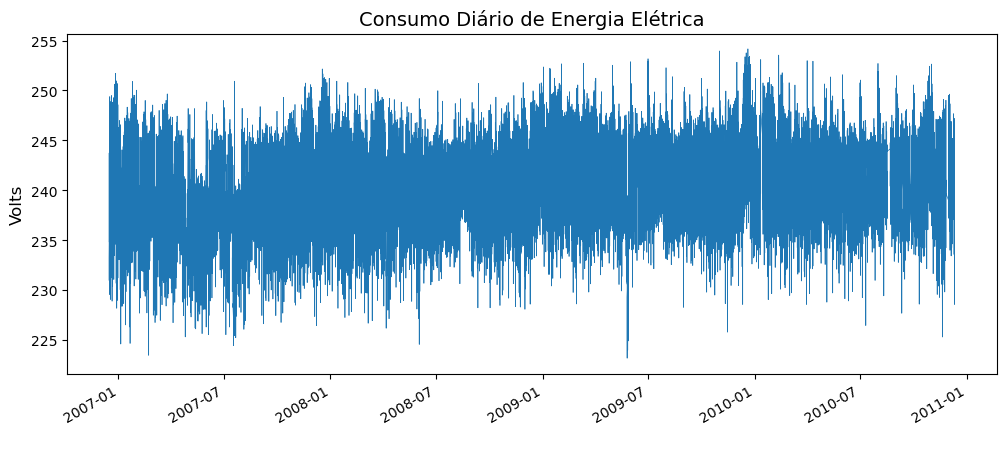

In [27]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['Voltage'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Volts', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

Em relação ao atributo Voltage, que representa o consumo de energia em volts, temos um consumo constante que está em tendência de alta ao longo dos anos. O pico do consumo foi entre dezembro/20 e janeiro/21. Essa informação mostra que os boxplots mostraram uma tendência correta de alta entre esses meses por conta do consumo do aquecedor no inverno europeu.

## 5. Processamento dos Dados para o Modelo Preditivo

In [28]:
# Base para o modelo
# Para esse modelo, será usado a métrica com o consumo total em volts
df_modelo = base[['Date', 'Voltage']]

# Confere o numéro de linhas e colunas
df_modelo

,Date,Voltage
0,2006-12-16,234.84
1,2006-12-16,233.63
2,2006-12-16,233.29
3,2006-12-16,233.74
4,2006-12-16,235.68
...,...,...
2075254,2010-11-26,240.43
2075255,2010-11-26,240.00
2075256,2010-11-26,239.82
2075257,2010-11-26,239.70


In [29]:
# Group by pela média do consumo diário
df_modelo = df_modelo.groupby(['Date'])[['Voltage']].mean()

# Confere o novo dataset
df_modelo

,Voltage
Date,
2006-12-16,236.243763
2006-12-17,240.087028
2006-12-18,241.231694
2006-12-19,241.999313
2006-12-20,242.308062
...,...
2010-12-07,240.218646
2010-12-08,240.794931
2010-12-09,241.619722


In [30]:
# Converte o objeto em dataframe pandas
df_modelo = pd.DataFrame(df_modelo)

# Confere dataset e número de linhas
df_modelo

,Voltage
Date,
2006-12-16,236.243763
2006-12-17,240.087028
2006-12-18,241.231694
2006-12-19,241.999313
2006-12-20,242.308062
...,...
2010-12-07,240.218646
2010-12-08,240.794931
2010-12-09,241.619722


In [31]:
# Reset do index para inclusão de colunas de tempo
df_modelo = df_modelo.reset_index()

# Confere dataset e número de linhas
df_modelo

,Date,Voltage
0,2006-12-16,236.243763
1,2006-12-17,240.087028
2,2006-12-18,241.231694
3,2006-12-19,241.999313
4,2006-12-20,242.308062
...,...,...
1428,2010-12-07,240.218646
1429,2010-12-08,240.794931
1430,2010-12-09,241.619722
1431,2010-12-10,240.260674


In [32]:
# Renomeia colunas de data para ds e variável target para y
df_modelo.rename(
    columns={"Date": "ds", "Voltage": "y"},
    inplace=True,
)

# Confere as mudanças no nome das colunas
df_modelo

,ds,y
0,2006-12-16,236.243763
1,2006-12-17,240.087028
2,2006-12-18,241.231694
3,2006-12-19,241.999313
4,2006-12-20,242.308062
...,...,...
1428,2010-12-07,240.218646
1429,2010-12-08,240.794931
1430,2010-12-09,241.619722
1431,2010-12-10,240.260674


Text(0, 0.5, 'Volts')

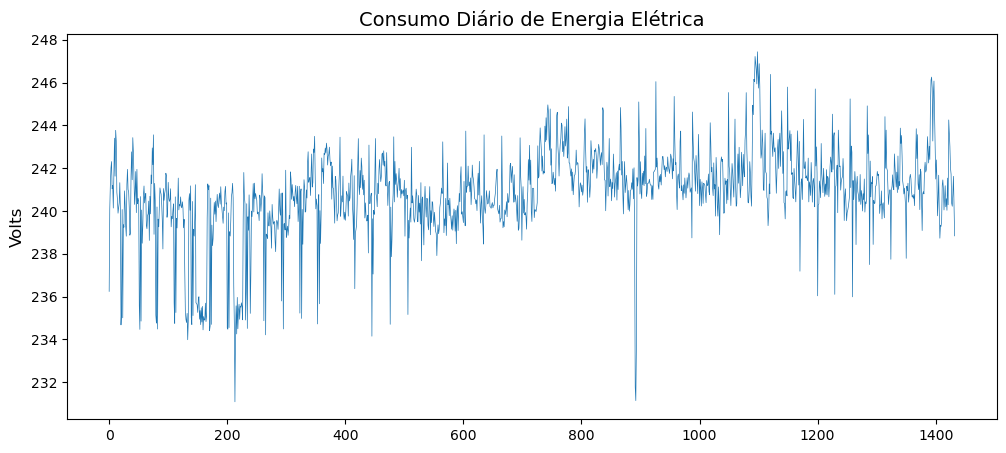

In [33]:
# Plot com a série temporal
# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Cria plot
df_modelo['y'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Volts', fontsize = 12)

## 6. Modelo Preditivo - Prophet

In [34]:
# Cria o modelo prophet como objeto python
modelo_v1 = Prophet()

In [35]:
# Fit do modelo
modelo_v1.fit(df_modelo)

21:51:48 - cmdstanpy - INFO - Chain [1] start processing
21:51:48 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Prepara o dataset com input das datas com as previsões
future = modelo_v1.make_future_dataframe(periods=365)

# Verifica as últimas datas
future.tail()

,ds
1793,2011-12-07
1794,2011-12-08
1795,2011-12-09
1796,2011-12-10
1797,2011-12-11


In [37]:
# Previsões com o Prophet
forecast = modelo_v1.predict(future)

In [38]:
# Visualiza as últimas previsões
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1793,2011-12-07,242.024770,238.855085,245.267040
1794,2011-12-08,242.240325,239.017283,245.553693
1795,2011-12-09,242.323293,239.033337,245.750287
1796,2011-12-10,242.276797,239.097936,245.492966
1797,2011-12-11,242.527022,239.062860,245.859419


## 7. Análise dos Resultados

Text(0.5, 1.0, 'Previsões Modelo Prophet - Versão 1')

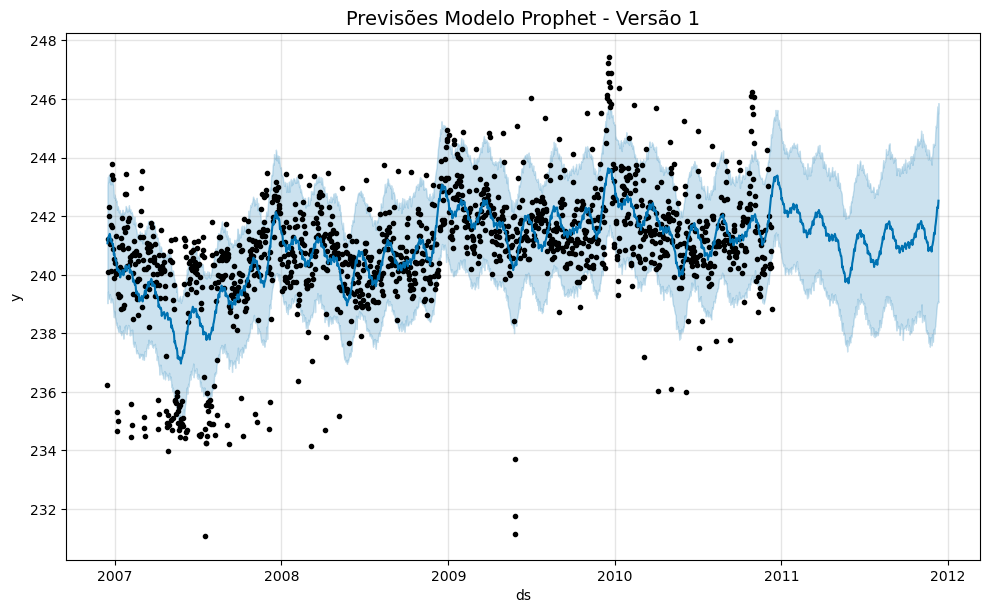

In [39]:
# Plot do modelo
fig1 = modelo_v1.plot(forecast)

# Define título
plt.title('Previsões Modelo Prophet - Versão 1', fontsize = 14)

Text(0.5, 1.0, 'Previsões Modelo Prophet com Changepoints - Versão 1')

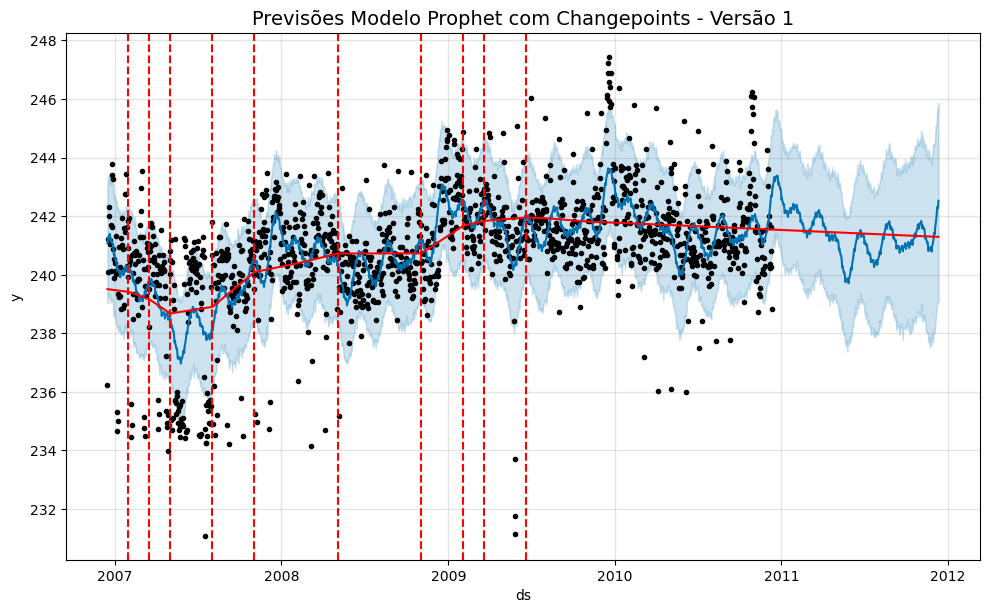

In [40]:
# Plot com os changepoints detectados pelo prophet
fig2 = modelo_v1.plot(forecast)
a = add_changepoints_to_plot(fig2.gca(), modelo_v1, forecast)

# Define título
plt.title('Previsões Modelo Prophet com Changepoints - Versão 1', fontsize = 14)

Os pontos vermelhos no gráfico são os chamados changepoints, ou seja, pontos na série temporal que houve uma mudança brusca no comportamento do uso de energia elétrica. Por meio desses changepoints, o modelo prophet consegue identificar esse pontos e ajustar a previsão com base nos changepoints. 

No gráfico acima, vemos que o prophet conseguiu identificar os pontos anteriores a 2009, porém não o fez em 2010 e 2011. Apesar disso ele conseguiu, aparentemente, prever os resultados com uma certa precisão.

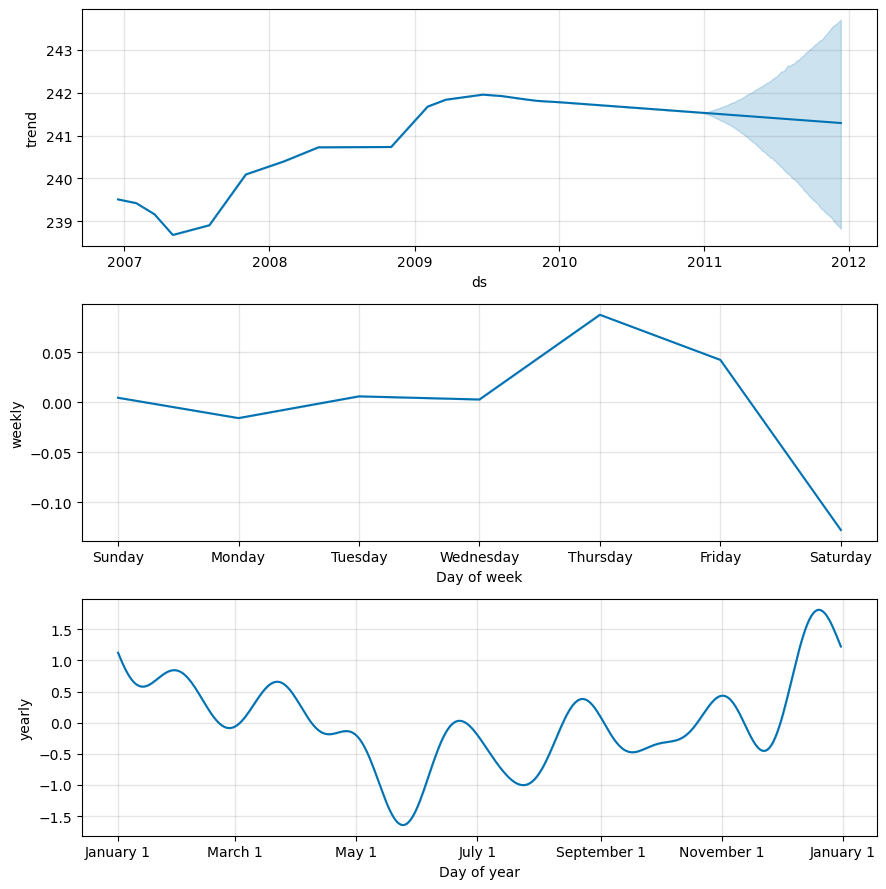

In [41]:
# Plot dos components
fig2 = modelo_v1.plot_components(forecast)

Em relação as sazonalidades do modelo, vemos que ano a ano tivemos uma estabilidade entre 2009 e 2011 e isso explica o motivo dos changepoints não serem detectados pelo modelo nesse período.

Na visão semanal, temos um pico de consumo nas quintas-ferias e na visão diário vemos que janeiro é o pico de consumo.

In [42]:
# Prepara para Cross Validation no Prophet
df_cv = cross_validation(modelo_v1, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

21:51:52 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1] done processing
21:51:53 - cmdstanpy - INFO - Chain [1] start processing
21:51:53 - cmdstanpy - INFO - Chain [1] done processing
21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:54 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Dataset com o Cross Validation
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2008-12-17,241.598171,239.519809,243.768138,243.313514,2008-12-16
1,2008-12-18,241.424401,239.301717,243.492255,242.859062,2008-12-16
2,2008-12-19,241.590667,239.447719,243.812547,241.866174,2008-12-16
3,2008-12-20,241.372879,239.194167,243.634622,242.565997,2008-12-16
4,2008-12-21,241.393959,239.285768,243.415334,241.720083,2008-12-16


In [44]:
# Métrica de avaliação do modelo
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,4.781301,2.186619,1.815673,0.007457,0.005954,0.007484,0.622642
1,37 days,4.879681,2.209000,1.821144,0.007479,0.005919,0.007508,0.613208
2,38 days,4.915409,2.217072,1.827972,0.007507,0.005907,0.007537,0.603774
3,39 days,4.923625,2.218924,1.833102,0.007530,0.005954,0.007560,0.603774
4,40 days,4.872861,2.207456,1.816796,0.007464,0.005954,0.007494,0.603774


Text(0.5, 1.0, 'Erro Médio % Modelo Prophet - Versão 1')

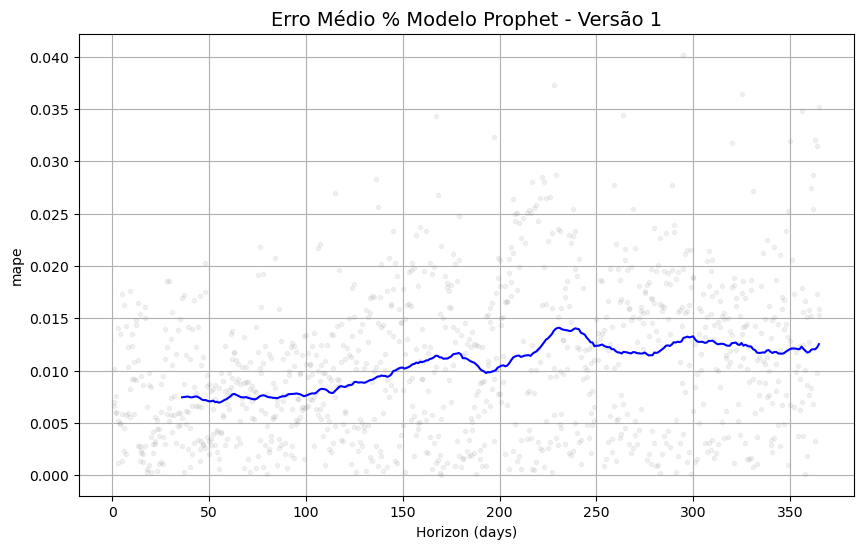

In [45]:
# plot com o % de erro médio do modelo
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Define título
plt.title('Erro Médio % Modelo Prophet - Versão 1', fontsize = 14)

No gráfico acima vemos que o erro% está em torno de 0,010% o que é bastante baixo. O modelo teve um comportamento muito bom com base nesse KPI de avaliação do modelo.

Text(0.5, 1.0, 'Erro Médio Modelo Prophet - Versão 1')

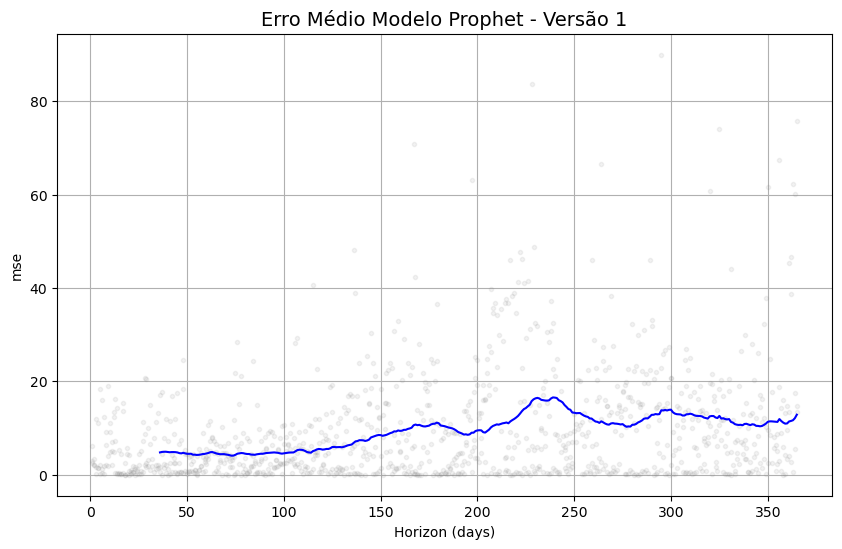

In [46]:
# plot com o % de erro médio do modelo
fig = plot_cross_validation_metric(df_cv, metric='mse')

# Define título
plt.title('Erro Médio Modelo Prophet - Versão 1', fontsize = 14)

Em relação a quantidae absoluta, vemos que o modelo tem errado em torno de 15 volts em média por dia. Isso é um número excelente para previsões de séries temporais.

## 8.Tunning do modelo

In [47]:
# Determina o cutoffs na série temporal
cutoffs = pd.to_datetime(['2008-02-18', '2009-08-20', '2010-03-15'])

In [48]:
# Função que avalia qual o melhor parâmetro que é possível utilizar no modelo
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Cria todas as combinações de parâmetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Uso do cross validation para avaliar todos os parâmetros
for params in all_params:
    m_tunning = Prophet(**params).fit(df_modelo)  # Fit do modelo com os parâmetros
    df_cv = cross_validation(m_tunning, cutoffs = cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Encontra os melhores parâmetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  1.918152
1                     0.001                     0.10  1.896065
2                     0.001                     1.00  1.869226
3                     0.001                    10.00  1.878703
4                     0.010                     0.01  1.736996
5                     0.010                     0.10  1.719944
6                     0.010                     1.00  1.738418
7                     0.010                    10.00  1.729807
8                     0.100                     0.01  1.576267
9                     0.100                     0.10  1.553336
10                    0.100                     1.00  1.561216
11                    0.100                    10.00  1.548351
12                    0.500                     0.01  3.042119
13                    0.500                     0.10  3.089660
14                    0.500                     1.00  3

In [49]:
# Mostra quais os melhores parâmetros para a nova versão do modelo
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


## 9. Modelo Preditivo v2 -Prophet

In [50]:
# Cria o modelo prophet como objeto python
modelo_v2 = Prophet(changepoint_prior_scale = 0.1, seasonality_prior_scale = 10.0)

In [51]:
# Fit do modelo
modelo_v2.fit(df_modelo)

21:53:15 - cmdstanpy - INFO - Chain [1] start processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Prepara o dataset com input das datas com as previsões
future = modelo_v2.make_future_dataframe(periods=365)
future.tail()

,ds
1793,2011-12-07
1794,2011-12-08
1795,2011-12-09
1796,2011-12-10
1797,2011-12-11


In [53]:
# Previsões com o Prophet
forecast = modelo_v2.predict(future)

In [54]:
# Visualiza as últimas previsões
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1793,2011-12-07,240.955042,231.675148,250.044260
1794,2011-12-08,241.158403,232.053553,250.525903
1795,2011-12-09,241.227761,231.924746,250.455055
1796,2011-12-10,241.170977,232.124670,250.251113
1797,2011-12-11,241.407218,232.025491,250.633539


## 10. Análise dos resultados

Text(0.5, 1.0, 'Previsões Modelo Prophet - Versão 2')

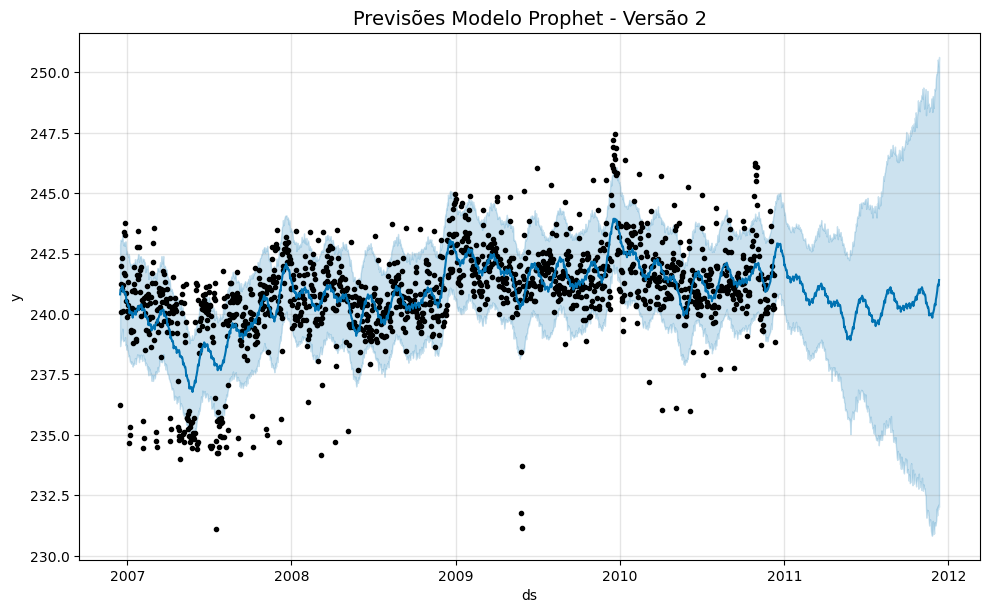

In [55]:
# Plot do modelo
fig1 = modelo_v2.plot(forecast)

# Define título
plt.title('Previsões Modelo Prophet - Versão 2', fontsize = 14)

A princípio o tunning do modelo teve um trabalho que resultou em overfitting do modelo e as previsões tiveram uma dispersão grande na faixa de tolerância do modelo, que é resultado do overfitting.

Text(0.5, 1.0, 'Previsões Modelo Prophet com Changepoints - Versão 2')

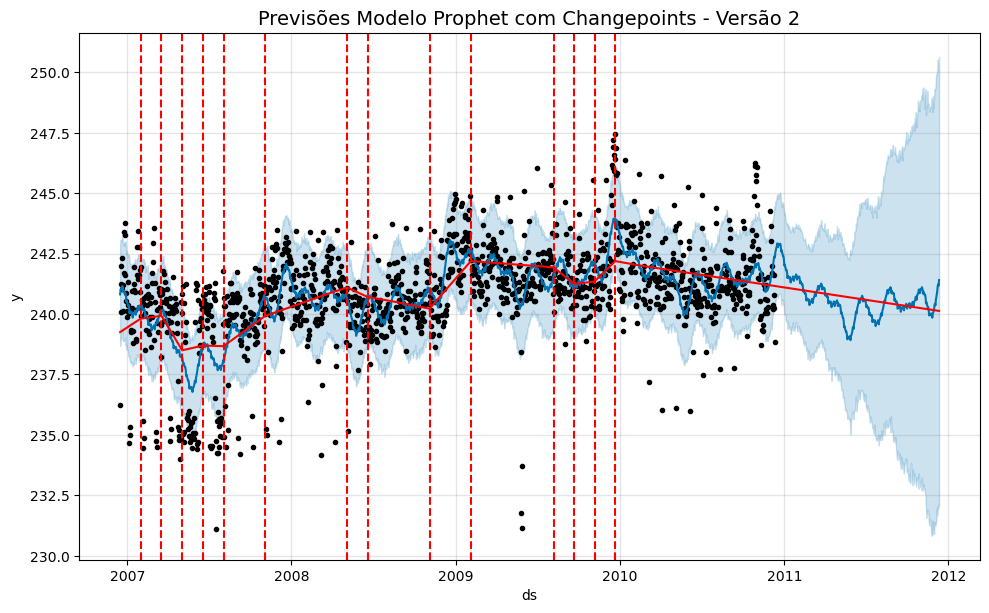

In [56]:
# Plot com os changepoints detectados pelo prophet
fig2 = modelo_v2.plot(forecast)
a = add_changepoints_to_plot(fig2.gca(), modelo_v2, forecast)

# Define título
plt.title('Previsões Modelo Prophet com Changepoints - Versão 2', fontsize = 14)

Nesta análise vemos que o modelo adicionou mais changepoints antes de 2010, o que conclui que o modelo teve um aparente overfitting. Isso mostra que ele está muito sensível as mudanças de comportamento do consumo de energia elétrica e que nas previsões para o próximo ano pode se tornar um problema.

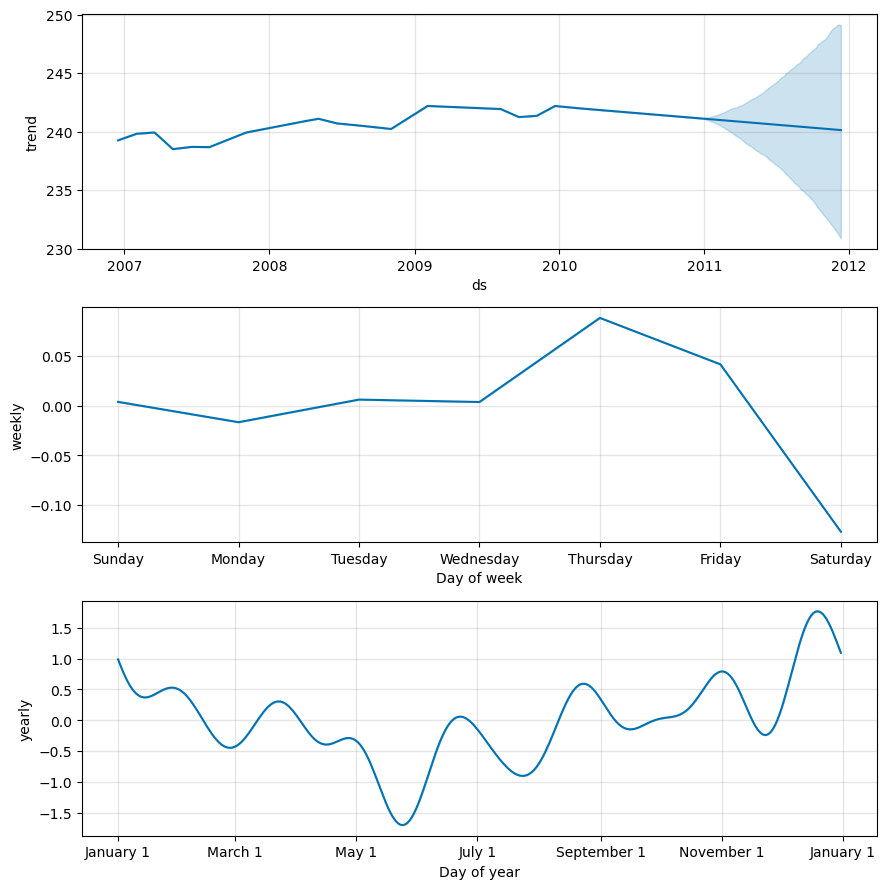

In [57]:
# Plot dos components
fig2 = modelo_v2.plot_components(forecast)

As sazonalidades tiveram um comportamento muito similar ao modelo v1.

In [58]:
# Prepara para Cross Validation no Prophet
df_cv = cross_validation(modelo_v2, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] start processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# Dataset com o Cross Validation
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2008-12-17,241.504299,239.367348,243.465822,243.313514,2008-12-16
1,2008-12-18,241.327673,239.185333,243.438029,242.859062,2008-12-16
2,2008-12-19,241.490601,239.416095,243.531445,241.866174,2008-12-16
3,2008-12-20,241.271809,239.241605,243.505572,242.565997,2008-12-16
4,2008-12-21,241.286237,239.289745,243.275256,241.720083,2008-12-16


In [60]:
# Métrica de avaliação do modelo
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,5.524801,2.350489,1.977538,0.008121,0.007038,0.008155,0.622642
1,37 days,5.643401,2.375584,1.987182,0.008161,0.006885,0.008196,0.613208
2,38 days,5.700180,2.387505,1.998182,0.008206,0.006910,0.008242,0.613208
3,39 days,5.725630,2.392829,2.007455,0.008246,0.007038,0.008283,0.613208
4,40 days,5.680051,2.383286,1.995340,0.008198,0.007038,0.008234,0.613208


Text(0.5, 1.0, 'Erro Médio % Modelo Prophet - Versão 2')

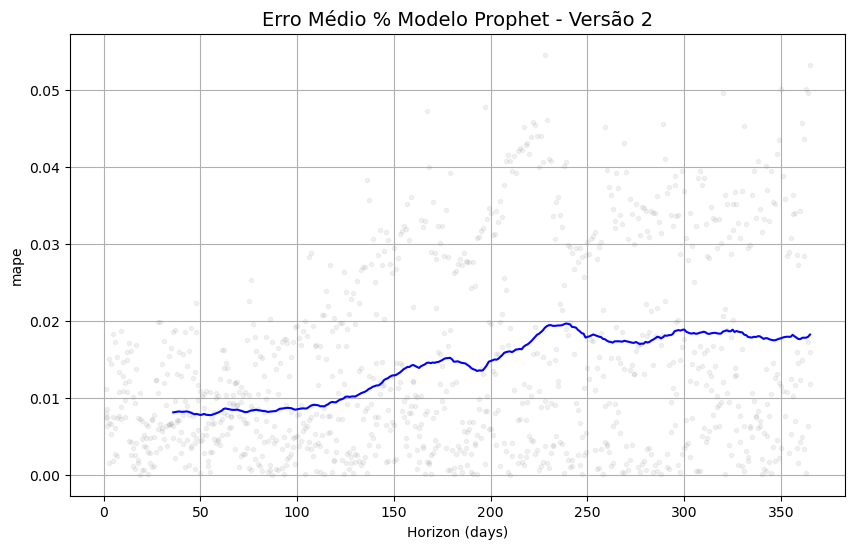

In [61]:
# plot com o % de erro médio do modelo
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Define título
plt.title('Erro Médio % Modelo Prophet - Versão 2', fontsize = 14)

Text(0.5, 1.0, 'Erro Médio Modelo Prophet - Versão 2')

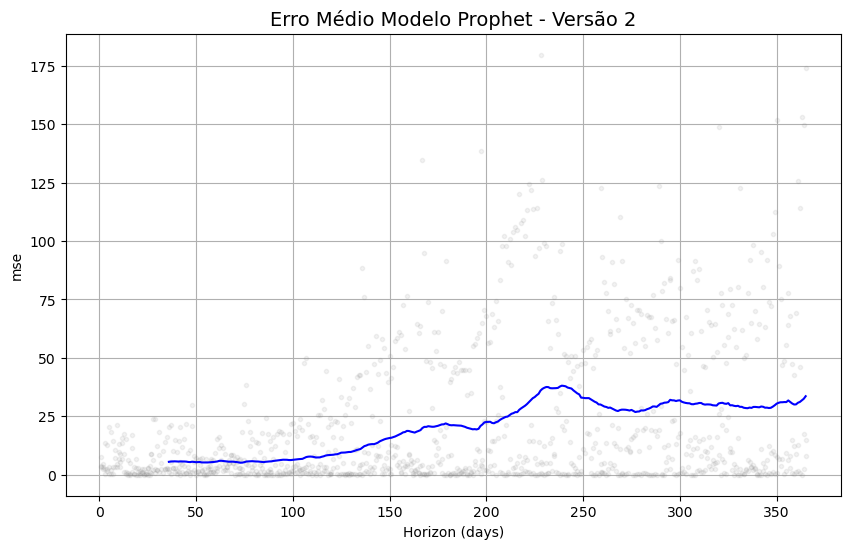

In [62]:
# plot com o % de erro médio do modelo
fig = plot_cross_validation_metric(df_cv, metric='mse')

# Define título
plt.title('Erro Médio Modelo Prophet - Versão 2', fontsize = 14)

Aqui vemos que o modelo teve um desempenho pior porque o erro% foi maior na v2 do que na v1. No erro médio, vemos que o modelo errou em até 25 volts, que correponde a 0,02% de erro. O modelo v1, teve um erro menor e não sofreu de overfitting.

## 11. Considerações Finais

Com base nas análises com modelo antes e após o tunning, fica claro que o melhor modelo é a versão 1 que apresenta um bom comportamento de previsão com uma faixa de tolerância adequada e erro médio % baixo. O modelo v1 pode sim entregar uma previsão de consumo de energia para os próximos 365 dias, contanto com valores máximos e mínimos.